In [1]:
# Setup
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz

import sccoda.datasets as scd

from sccoda.model.scCODA_model import EricaModel

### Loading Data

In [2]:
# Read data into pandas from csv

cell_counts = scd.haber()

print(cell_counts)

            Mouse  Endocrine  Enterocyte  Enterocyte.Progenitor  Goblet  Stem  \
0       Control_1         36          59                    136      36   239   
1       Control_2          5          46                     23      20    50   
2       Control_3         45          98                    188     124   250   
3       Control_4         26         221                    198      36   131   
4  H.poly.Day10_1         42          71                    203     147   271   
5  H.poly.Day10_2         40          57                    383     170   321   
6   H.poly.Day3_1         52          75                    347      66   323   
7   H.poly.Day3_2         65         126                    115      33    65   
8          Salm_1         37         332                    113      59    90   
9          Salm_2         32         373                    116      67   117   

    TA  TA.Early  Tuft  
0  125       191    18  
1   11        40     5  
2  155       365    33  
3  130  

### Converting data to anndata object

In [3]:
# Convert data to anndata object
data_all = dat.from_pandas(cell_counts, covariate_columns=["Mouse"])

# Extract condition from mouse name and add it as an extra column to the covariates
data_all.obs["Condition"] = data_all.obs["Mouse"].str.replace(r"_[0-9]", "", regex=True)
print(data_all)

AnnData object with n_obs × n_vars = 10 × 8
    obs: 'Mouse', 'Condition'


In [4]:

# Select control and salmonella data
data_salm = data_all[data_all.obs["Condition"].isin(["Control", "Salm"])]
print(data_salm.obs)


       Mouse Condition
0  Control_1   Control
1  Control_2   Control
2  Control_3   Control
3  Control_4   Control
8     Salm_1      Salm
9     Salm_2      Salm


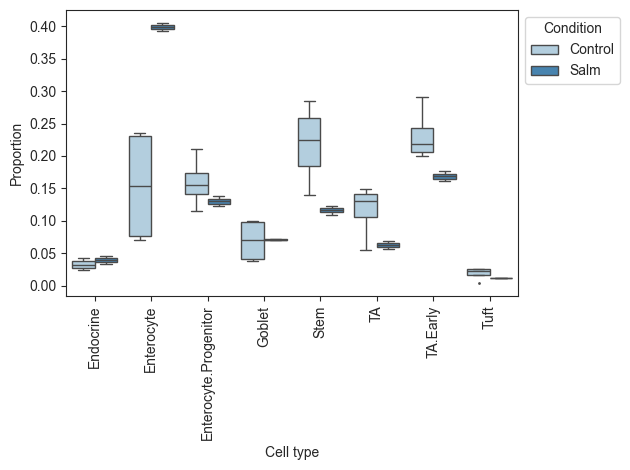

In [5]:
viz.boxplots(data_salm, feature_name="Condition")
plt.show()

### Building Design Matrix for Covariate

In [6]:
import patsy as pt

covariate_matrix_full = pt.dmatrix("Condition", data_salm.obs)
covariate_matrix=covariate_matrix_full[:,1:]
covariate_names = ["Condition"]  

In [7]:
import numpy as np

cell_types = list(data_salm.var.index)
ref_idx = cell_types.index("Goblet")

model_salm = EricaModel(
    reference_cell_type=ref_idx,
    data_matrix=data_salm.X.astype("float64"),
    covariate_matrix=np.array(covariate_matrix),
    cell_types=cell_types,
    covariate_names=covariate_names,
    formula="Condition"
)


We first run the default parameters as a baseline.

In [8]:
# Run HMC sampling
sim_results = model_salm.sample_hmc(
    num_results=5000,  
    num_burnin=1000,
    step_size=0.01,
    num_leapfrog_steps=10
)

# Summary
print(sim_results.summary())


2025-10-02 15:41:33.073636: I external/local_xla/xla/service/service.cc:163] XLA service 0x179e0a2f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-02 15:41:33.073698: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
  0%|          | 0/5000 [00:00<?, ?it/s]2025-10-02 15:41:33.203894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759434093.896135 2194026 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 5000/5000 [00:14<00:00, 348.29it/s]


MCMC sampling finished. (20.247 sec)
Acceptance rate: 54.5%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.096        34.349438
Enterocyte                       2.314       116.115533
Enterocyte.Progenitor            2.508       140.975437
Goblet                           1.733        64.947917
Stem                             2.692       169.454706
TA                               2.096        93.371454
TA.Early                         2.849       198.261263
Tuft                             0.423        17.524251


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.587688   
          Enterocyte                    1.349371

We now run EricaModel 6 different times, changing one default parameter for each run. First, we begin by changing the mean of the alpha random variable (the intercept for the GLM) to 1.0. We then change the standard deviation of the alpha random variable to 2.0. We then change the sigma parameter (which controls the magnitude of the raw effect) to 0.5. We also alter the gamma random variable (drawn from Normal distribution which controls sign and magnitude of the raw effect). First, we change the mean from 0.0 to 0 and then the standard deviation from 1.0 to 0.5. Finaly, we change the log-odds scale from 50.0 to 25. 

In [9]:
default_priors = {
    "alpha_loc": 0.0,
    "alpha_sd": 5.0,
    "sigma_hc_scale": 1.0,
    "gamma_loc": 0.0,
    "gamma_sd": 1.0,
    "tau_temperature": 50.0
}

# Each dict changes only one prior from the default
priors_list = [
    {**default_priors, "alpha_loc": 0.5},
    {**default_priors, "alpha_loc": 10.0},          
    {**default_priors, "alpha_sd": 0.5},
    {**default_priors, "alpha_sd": 10.0},            
    {**default_priors, "sigma_hc_scale": 0.25},   
    {**default_priors, "sigma_hc_scale": 5.0},   
    {**default_priors, "gamma_loc": 0.25}, 
    {**default_priors, "gamma_loc": 5.0},          
    {**default_priors, "gamma_sd": 0.25},
    {**default_priors, "gamma_sd": 5.0},             
    {**default_priors, "tau_temperature": 1.0},
    {**default_priors, "tau_temperature": 100.0}
]

results = []

for i, priors in enumerate(priors_list, 1):
    print(f"\n=== Running model with prior {i}/{len(priors_list)} ===\n")
    
    cell_types = list(data_salm.var.index)
    ref_idx = cell_types.index("Goblet")

    model = EricaModel(
        reference_cell_type=ref_idx,
        data_matrix=data_salm.X.astype("float64"),
        covariate_matrix=covariate_matrix,
        cell_types=cell_types,
        covariate_names=covariate_names,
        formula="Condition",
        **priors  
    )
    
    # Run HMC sampling
    sample_result = model.sample_hmc(num_results=5000, num_burnin=1000)
    results.append(sample_result)
    
    # Print summary of the last run
    print(sample_result.summary())



=== Running model with prior 1/12 ===



100%|██████████| 5000/5000 [00:13<00:00, 378.13it/s]


MCMC sampling finished. (18.642 sec)
Acceptance rate: 51.8%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.097        34.522016
Enterocyte                       2.320       117.283874
Enterocyte.Progenitor            2.497       139.993679
Goblet                           1.735        65.339534
Stem                             2.701       171.673990
TA                               2.090        93.185979
TA.Early                         2.832       195.702817
Tuft                             0.406        17.298110


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.690947   
          Enterocyte                    1.344098

100%|██████████| 5000/5000 [00:13<00:00, 366.69it/s]


MCMC sampling finished. (19.010 sec)
Acceptance rate: 52.0%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.321        34.370029
Enterocyte                       2.546       117.001286
Enterocyte.Progenitor            2.730       140.637397
Goblet                           1.955        64.792181
Stem                             2.914       169.048377
TA                               2.333        94.555307
TA.Early                         3.069       197.390683
Tuft                             0.629        17.204740


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.553160   
          Enterocyte                    1.348954

100%|██████████| 5000/5000 [00:13<00:00, 367.89it/s]


MCMC sampling finished. (18.652 sec)
Acceptance rate: 56.7%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                       -0.102        57.789571
Enterocyte                       0.674       125.563088
Enterocyte.Progenitor            0.679       126.192476
Goblet                           0.211        79.028483
Stem                             0.817       144.865877
TA                               0.383        93.860377
TA.Early                         0.942       164.154544
Tuft                            -0.385        43.545585


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                          0.0        57.789571   
          Enterocyte                         0.0

100%|██████████| 5000/5000 [00:14<00:00, 345.85it/s]


MCMC sampling finished. (19.568 sec)
Acceptance rate: 37.0%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.175        34.866433
Enterocyte                       2.375       115.760633
Enterocyte.Progenitor            2.542       136.800622
Goblet                           1.806        65.531081
Stem                             2.768       171.489931
TA                               2.149        92.344353
TA.Early                         2.922       200.041441
Tuft                             0.523        18.165507


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.774810   
          Enterocyte                    1.370715

100%|██████████| 5000/5000 [00:12<00:00, 385.23it/s]


MCMC sampling finished. (18.581 sec)
Acceptance rate: 51.0%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.098        34.767777
Enterocyte                       2.321       118.118813
Enterocyte.Progenitor            2.501       141.413894
Goblet                           1.730        65.411037
Stem                             2.667       166.949439
TA                               2.084        93.194714
TA.Early                         2.836       197.688193
Tuft                             0.409        17.456132


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.122597   
          Enterocyte                    1.312115

100%|██████████| 5000/5000 [00:13<00:00, 375.47it/s]


MCMC sampling finished. (18.342 sec)
Acceptance rate: 62.3%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.103        35.163401
Enterocyte                       2.271       113.069852
Enterocyte.Progenitor            2.494       141.317028
Goblet                           1.749        67.088040
Stem                             2.687       171.400991
TA                               2.094        94.727637
TA.Early                         2.815       194.806311
Tuft                             0.401        17.426740


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.962674   
          Enterocyte                    1.390716

100%|██████████| 5000/5000 [00:14<00:00, 339.38it/s]


MCMC sampling finished. (19.989 sec)
Acceptance rate: 53.5%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.101        34.519034
Enterocyte                       2.315       116.223013
Enterocyte.Progenitor            2.506       140.683244
Goblet                           1.743        65.595748
Stem                             2.683       167.923895
TA                               2.093        93.084797
TA.Early                         2.856       199.639027
Tuft                             0.412        17.331244


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        24.475368   
          Enterocyte                     1.37326

100%|██████████| 5000/5000 [00:14<00:00, 343.67it/s]


MCMC sampling finished. (20.279 sec)
Acceptance rate: 43.2%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        0.970        32.510570
Enterocyte                       2.234       115.072833
Enterocyte.Progenitor            2.463       144.685911
Goblet                           1.684        66.391249
Stem                             2.609       167.429985
TA                               2.015        92.440506
TA.Early                         2.786       199.849636
Tuft                             0.299        16.619310


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        22.554881   
          Enterocyte                    1.435777

100%|██████████| 5000/5000 [00:12<00:00, 396.89it/s]


MCMC sampling finished. (17.594 sec)
Acceptance rate: 60.6%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.101        34.674772
Enterocyte                       2.338       119.463680
Enterocyte.Progenitor            2.496       139.911823
Goblet                           1.723        64.586951
Stem                             2.685       169.019212
TA                               2.097        93.879532
TA.Early                         2.834       196.176034
Tuft                             0.405        17.287996


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        25.238709   
          Enterocyte                    1.284596

100%|██████████| 5000/5000 [00:12<00:00, 399.61it/s]


MCMC sampling finished. (17.345 sec)
Acceptance rate: 36.2%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.070        35.918327
Enterocyte                       2.226       114.119672
Enterocyte.Progenitor            2.448       142.486557
Goblet                           1.688        66.636179
Stem                             2.607       167.042397
TA                               2.022        93.060299
TA.Early                         2.779       198.392552
Tuft                             0.342        17.344018


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                      0.00000        25.197830   
          Enterocyte                     1.41415

100%|██████████| 5000/5000 [00:12<00:00, 400.83it/s]


MCMC sampling finished. (17.412 sec)
Acceptance rate: 48.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.010        31.824323
Enterocyte                       2.354       122.025600
Enterocyte.Progenitor            2.461       135.806470
Goblet                           1.713        64.278863
Stem                             2.710       174.204667
TA                               2.099        94.559650
TA.Early                         2.825       195.435589
Tuft                             0.375        16.864838


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.211248        30.382107   
          Enterocyte                    1.220072

100%|██████████| 5000/5000 [00:13<00:00, 379.17it/s]


MCMC sampling finished. (18.367 sec)
Acceptance rate: 60.1%
Compositional Analysis summary:

Data: 6 samples, 8 cell types
Reference index: 3
Formula: Condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
Endocrine                        1.144        34.675450
Enterocyte                       2.349       115.703623
Enterocyte.Progenitor            2.539       139.914559
Goblet                           1.780        65.498808
Stem                             2.738       170.721222
TA                               2.142        94.069319
TA.Early                         2.882       197.163226
Tuft                             0.446        17.253792


Effects:
                                 Final Parameter  Expected Sample  \
Covariate Cell Type                                                 
Condition Endocrine                     0.000000        24.768840   
          Enterocyte                    1.357487

In [10]:
def values(arr):
        mean = arr.mean(axis=(0,1))               
        lo = np.percentile(arr, 2.5, axis=(0,1))  
        hi = np.percentile(arr, 97.5, axis=(0,1))  
        return mean, lo, hi

In [11]:
def summarize(data, prior_label, reference=0):
    "Extract summaries from inference data object"
    
    pred = data.posterior_predictive["prediction"].values
    cell_types = list(data.posterior_predictive.cell_type.values)
    reference_name = cell_types[reference]
    
    # Overall expected samples
    pred_mean, pred_lo, pred_hi = values(pred)            
    pred_mean = pred_mean.mean(axis=0)                   
    pred_lo   = pred_lo.mean(axis=0)
    pred_hi   = pred_hi.mean(axis=0)
    
     # intercept expected sample
    alpha = data.posterior["alpha"].values  
    alpha_mean, alpha_lo, alpha_hi = values(alpha)  
    
     # effect expected sample
    beta = data.posterior["beta"].values[..., 0, :]
    beta_mean, beta_lo, beta_hi = values(beta)
    
    #log fold change
    ref_pred = pred[..., reference:reference+1]
    logfc = np.log2(pred / ref_pred)                    
    logfc_mean, logfc_lo, logfc_hi = values(logfc)       
    logfc_mean = logfc_mean.mean(axis=0)           
    logfc_lo   = logfc_lo.mean(axis=0)
    logfc_hi   = logfc_hi.mean(axis=0)
    
    rows = []
    for i, ct in enumerate(cell_types):
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "expected_sample",
            "mean": pred_mean[i], "lo": pred_lo[i], "hi": pred_hi[i]
        })
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "intercept_expected_sample",
            "mean": alpha_mean[i], "lo": alpha_lo[i], "hi": alpha_hi[i]
        })
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "effect_expected_sample",
            "mean": beta_mean[i], "lo": beta_lo[i], "hi": beta_hi[i]
        })
        rows.append({
            "cell_type": ct, "reference": reference_name, "prior": prior_label,
            "metric": "log2FC",
            "mean": logfc_mean[i], "lo": logfc_lo[i], "hi": logfc_hi[i]
        })

    return pd.DataFrame(rows)

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_grid(df, param_name=None):
    metrics = ["expected_sample", "log2FC", "effect_expected_sample", "intercept_expected_sample"]
    titles  = ["Expected Samples", "Log2 Fold Change", "Effect Expected Sample", "Intercept Expected Sample"]

    n_metrics = len(metrics)
    cell_types = df["cell_type"].unique()
    n_cells = len(cell_types)

    prior_order = ["low", "default", "high"]

    palette = {
        "expected_sample": "#4C72B0",         
        "log2FC": "#55A868",                   
        "effect_expected_sample": "#C44E52",   
        "intercept_expected_sample": "#8172B2" 
    }

    fig, axes = plt.subplots(n_cells, n_metrics, figsize=(4*n_metrics, 3*n_cells), sharex=False)

    if n_cells == 1:
        axes = axes[np.newaxis, :]  

    for i, ct in enumerate(cell_types):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            sub = df[(df["cell_type"] == ct) & (df["metric"] == metric)].copy()

            # sort priors
            sub["prior"] = pd.Categorical(sub["prior"], categories=prior_order, ordered=True)
            sub = sub.sort_values("prior")

            color = palette[metric]

            if metric == "expected_sample":
                ax.bar(sub["prior"], sub["mean"], color=color, alpha=0.8)
            else:
                ax.plot(sub["prior"], sub["mean"], marker="o", color=color, linewidth=2)
                ax.fill_between(
                    sub["prior"], sub["lo"], sub["hi"],
                    color=color, alpha=0.2
                )

            ax.set_xticks(range(len(prior_order)))
            ax.set_xticklabels(prior_order, rotation=45, ha="right", fontsize=9)
            ax.tick_params(axis="y", labelsize=8)
            ax.grid(True, linestyle="--", alpha=0.4)

            if i == 0:
                ax.set_title(titles[j], fontsize=11, fontweight="bold")
            if j == 0:
                ax.set_ylabel(ct, fontsize=9, fontweight="bold")
            else:
                ax.set_ylabel("")

    if param_name is not None:
        fig.suptitle(f"{param_name}", fontsize=14, fontweight="bold", y=1.02)
        
    plt.tight_layout()
    return fig, axes

In [ ]:
# parameter alpha_loc
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[0], prior_label="low", reference=ref_idx)
df_high = summarize(results[1], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)

plot_grid(df_all, param_name="alpha_loc")
plt.show()

In [ ]:
# parameter alpha_sd
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[2], prior_label="low", reference=ref_idx)
df_high = summarize(results[3], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="alpha_sd")
plt.show()

In [ ]:
# paramter sigma_hc_scale
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[4], prior_label="low", reference=ref_idx)
df_high = summarize(results[5], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="sigma_hc_scale")
plt.show()

In [ ]:
# parameter gamma_loc
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[6], prior_label="low", reference=ref_idx)
df_high = summarize(results[7], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="gamma_loc")
plt.show()

In [ ]:
# parameter gamma_sd
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[8], prior_label="low", reference=ref_idx)
df_high = summarize(results[9], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="gamma_sd")
plt.show()

In [ ]:
# parameter tau_temperature
df_default = summarize(sim_results, prior_label="default", reference=ref_idx)
df_low = summarize(results[10], prior_label="low", reference=ref_idx)
df_high = summarize(results[11], prior_label="high", reference=ref_idx)
df_all = pd.concat([df_default, df_low, df_high], ignore_index=True)
plot_grid(df_all, param_name="tau_temperature")
plt.show()


In [83]:
import scanpy as sc
adata = sc.read_h5ad("../sccoda/datasets/kang.h5ad")

print(adata)


AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'label', 'cluster', 'cell_type', 'replicate', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters'
    var: 'name'
    obsm: 'X_pca', 'X_umap'


In [89]:
print(adata.obs[["replicate", "label"]].drop_duplicates())
print(len(adata.obs[["replicate", "label"]].drop_duplicates()))


                     replicate label
index                               
AAACATACATTTCC-1  patient_1016  ctrl
AAACATACCAGAAA-1  patient_1256  ctrl
AAACATACCATGCA-1  patient_1488  ctrl
AAACATACCTGGTA-1  patient_1039  ctrl
AAACATACGGCATT-1  patient_1015  ctrl
AAACATACTGCGTA-1   patient_107  ctrl
AAACCGTGGTCAAC-1  patient_1244  ctrl
AAACTTGACTCTTA-1   patient_101  ctrl
AAACATACCAAGCT-2   patient_101  stim
AAACATACCCCTAC-2  patient_1488  stim
AAACATACGTTGCA-2  patient_1256  stim
AAACATACTATGGC-2  patient_1015  stim
AAACATACTCAGGT-2  patient_1016  stim
AAACATTGACCTGA-2  patient_1244  stim
AAAGCAGAACGGGA-2  patient_1039  stim
AAAGCCTGGTGAGG-2   patient_107  stim
16


In [90]:
adata.obs["sample_id"] = adata.obs["replicate"].astype(str) + "_" + adata.obs["label"].astype(str)
cov_df = adata.obs[["sample_id", "label"]].drop_duplicates().set_index("sample_id")
cov_df = cov_df.rename(columns={"label": "condition"})
print(cov_df)

                  condition
sample_id                  
patient_1016_ctrl      ctrl
patient_1256_ctrl      ctrl
patient_1488_ctrl      ctrl
patient_1039_ctrl      ctrl
patient_1015_ctrl      ctrl
patient_107_ctrl       ctrl
patient_1244_ctrl      ctrl
patient_101_ctrl       ctrl
patient_101_stim       stim
patient_1488_stim      stim
patient_1256_stim      stim
patient_1015_stim      stim
patient_1016_stim      stim
patient_1244_stim      stim
patient_1039_stim      stim
patient_107_stim       stim


In [ ]:
coda_data = dat.from_scanpy(adata, cell_type_identifier="cell_type", sample_identifier="sample_id", covariate_df=cov_df)
print(coda_data)

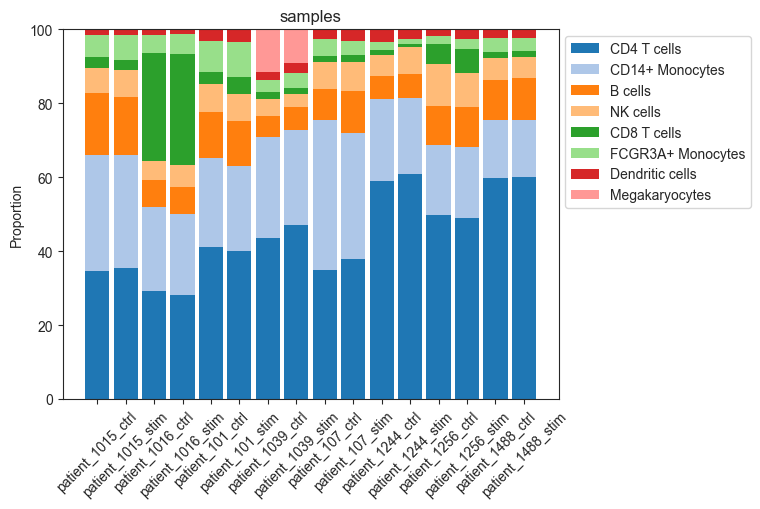

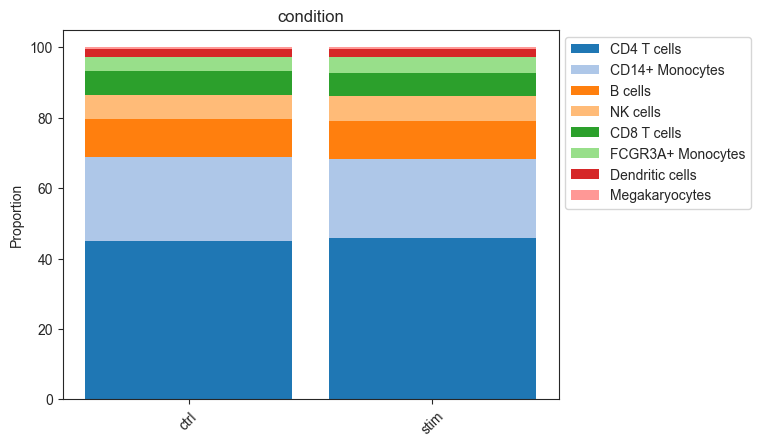

In [95]:
# Stacked barplot for each sample
viz.stacked_barplot(coda_data, feature_name="samples")
plt.show()

# Stacked barplot for the levels of "Condition"
viz.stacked_barplot(coda_data, feature_name="condition")
plt.show()

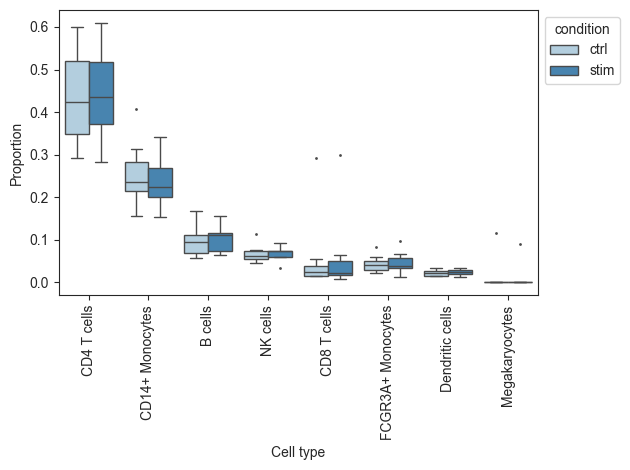

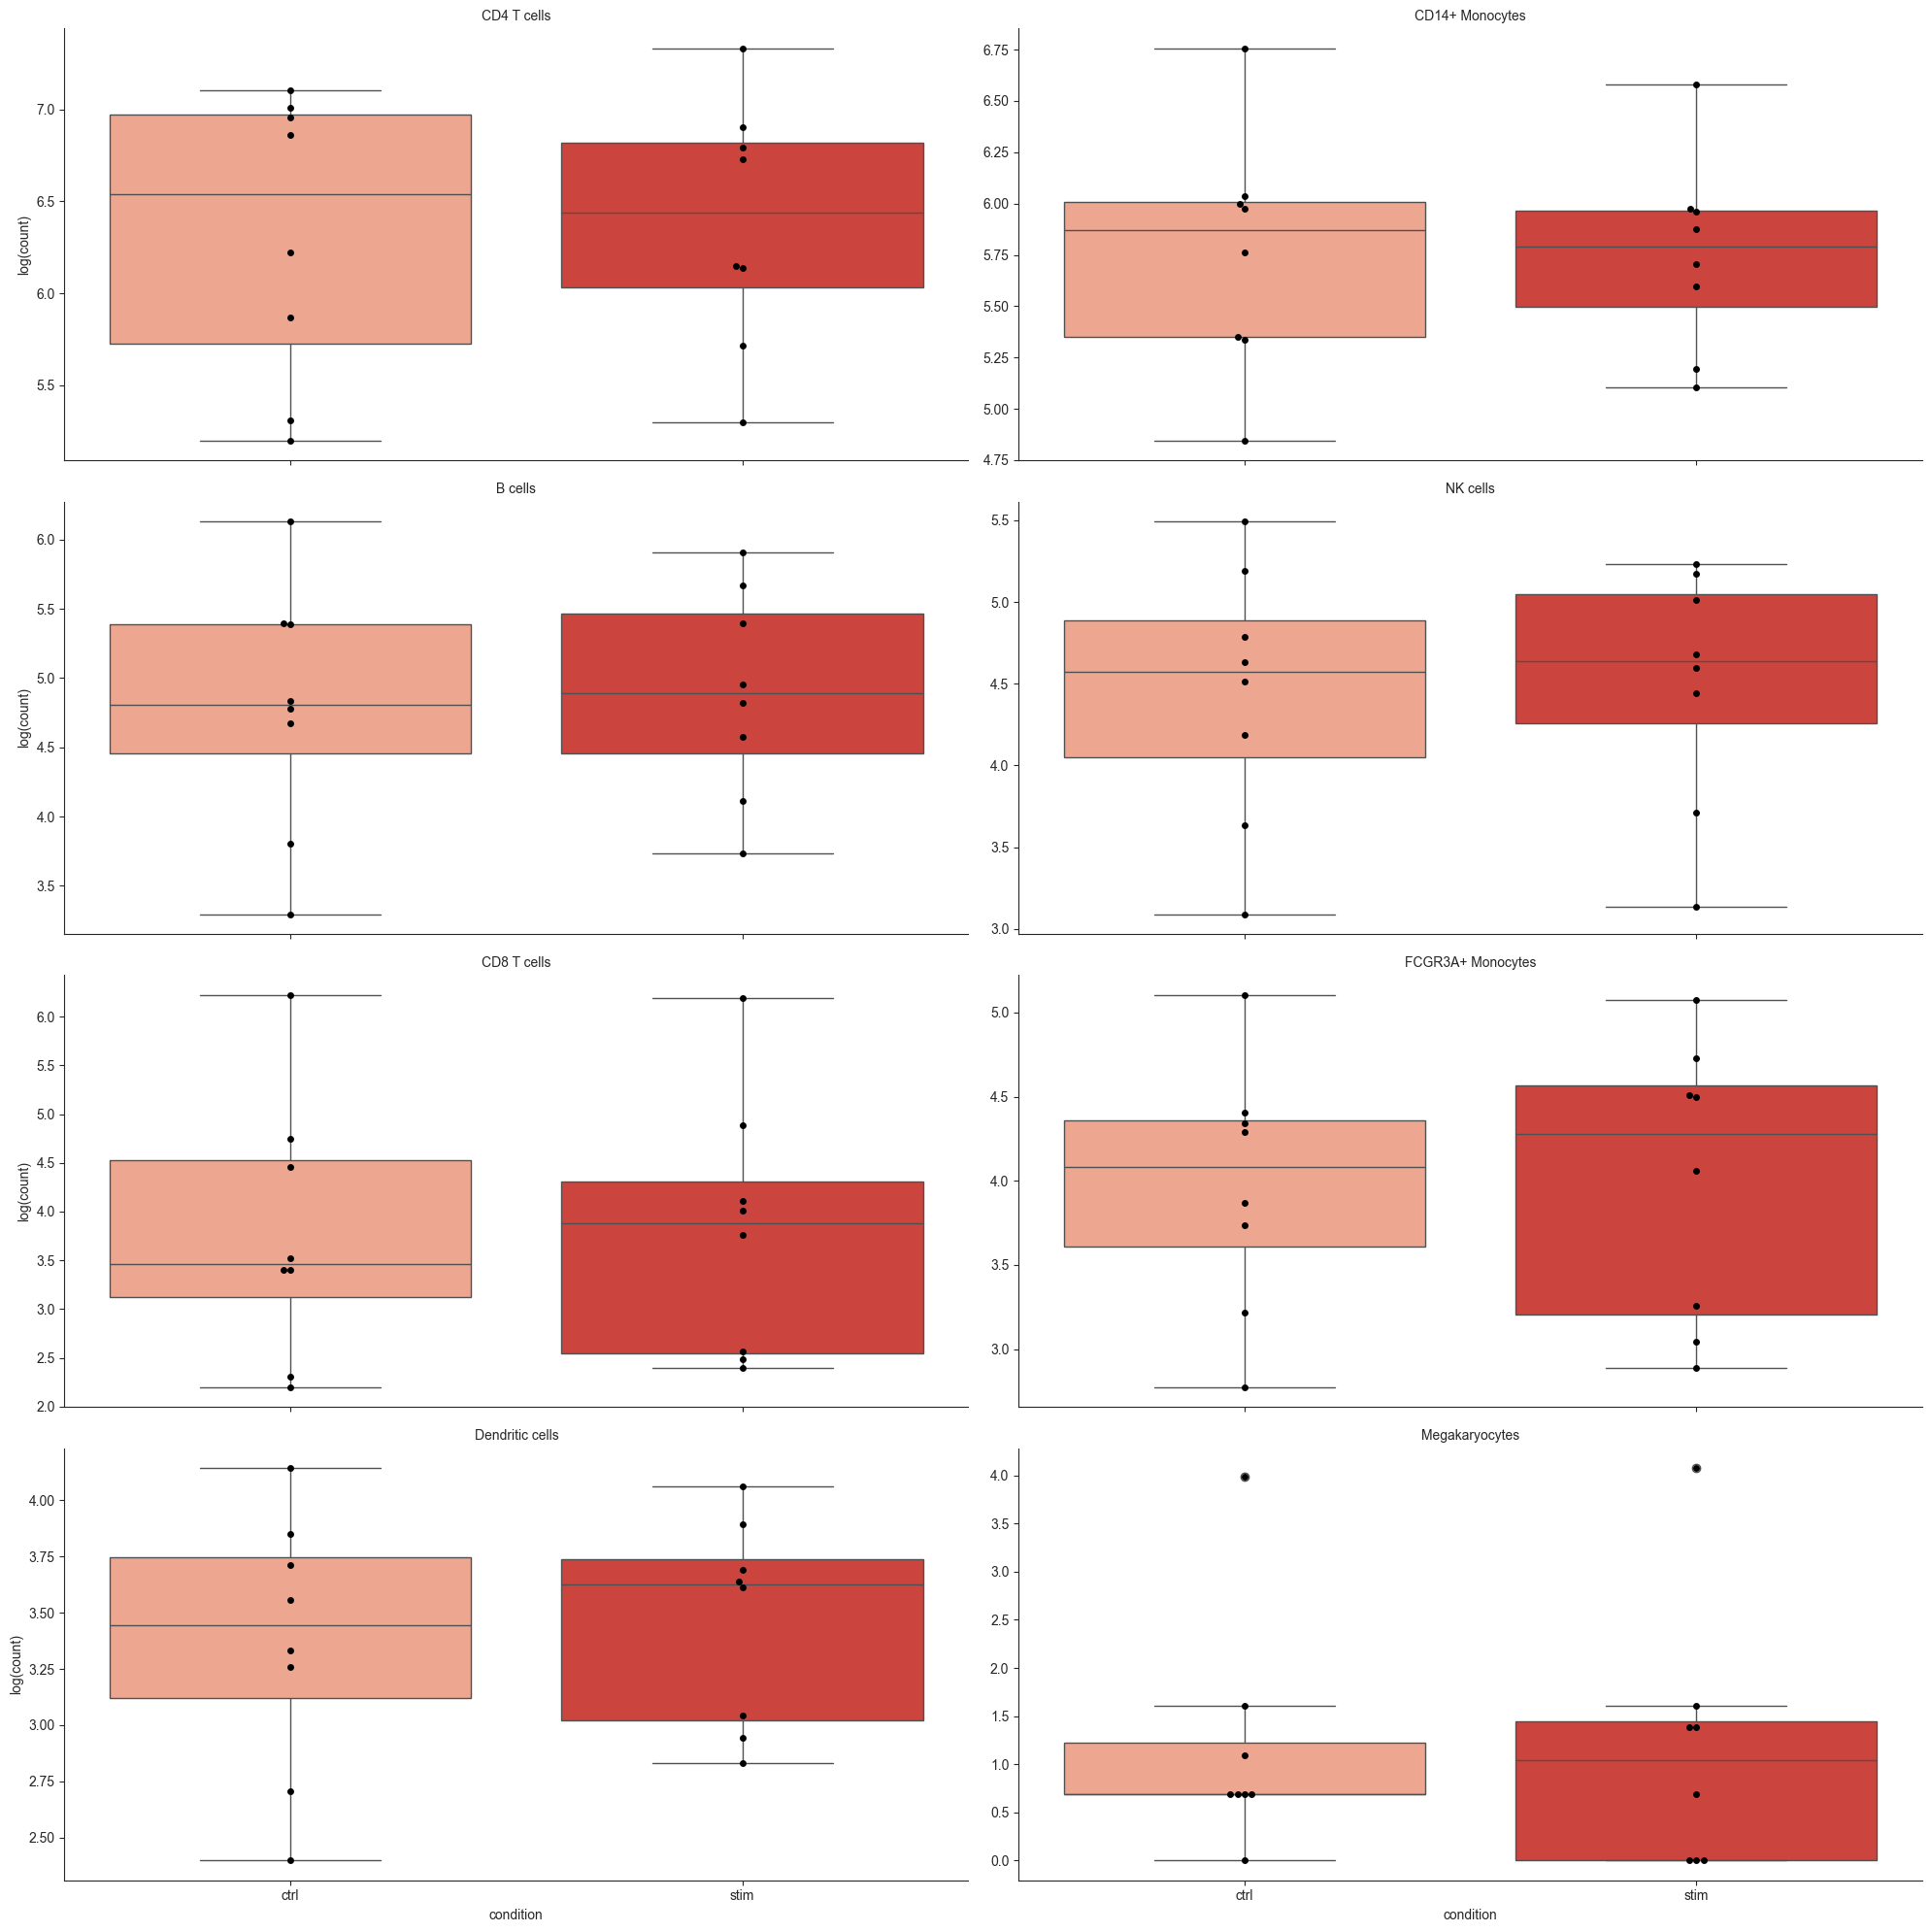

In [96]:
# Grouped boxplots. No facets, relative abundance, no dots.
viz.boxplots(
    coda_data,
    feature_name="condition",
    plot_facets=False,
    y_scale="relative",
    add_dots=False,
)
plt.show()

# Grouped boxplots. Facets, log scale, added dots and custom color palette.
viz.boxplots(
    coda_data,
    feature_name="condition",
    plot_facets=True,
    y_scale="log",
    add_dots=True,
    cmap="Reds",
)
plt.show()

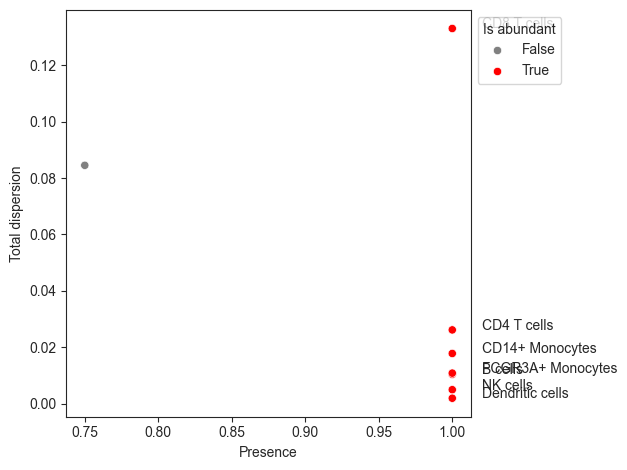

In [97]:
viz.rel_abundance_dispersion_plot(
    data=coda_data,
    abundant_threshold=0.9
)
plt.show()

In [ ]:
model_salm = mod.CompositionalAnalysis(coda_data, formula="condition", reference_cell_type="Goblet")